In [2]:
# 必要なパッケージを読み込む
using DelimitedFiles, DataFrames,  Plots
Plots.default(fontfamily="IPAexGothic")
# 前提として、以下のファイルが既に存在している
include("calc_IPW.jl")          # リグレット計算の基本関数
include("file_operate.jl")      # ファイル操作用関数
include("module_regret.jl") # 先ほど定義した新しいモジュール

# RankChangeIntervalモジュールを使用
using .RankChangeInterval



   Resolving package versions...
  No Changes to `/workspaces/inulab_julia_devcontainer/Project.toml`
  No Changes to `/workspaces/inulab_julia_devcontainer/Manifest.toml`


In [3]:
# 1. データの読み込み
function load_data(method_name="simp", repeat_num=1, criteria_num=6)
    # 効用値行列の読み込み
    utility_data = read_utility_value()[5]
    
    # 区間重要度の読み込み
    method_weights = read_method_weights(method_name, repeat_num, criteria_num)[5]
    
    return utility_data, method_weights
end

# 2. 最適なtの範囲を計算
function calculate_t_range(method_weights)
    t_range = find_optimal_trange(method_weights.L, method_weights.R)
    # println("最適t範囲: [", t_range[1], ", ", t_range[2], "]")
    return t_range
end
# 3. アベイルスペースに基づく順位変化点を分析
function analyze_rank_changes(utility_data, method_weights, t_range)
    utility_matrix = Matrix(utility_data)
    results = RankChangeInterval.analyze_all_alternatives_with_avail_space(utility_matrix, method_weights, t_range)
    # println(results)
    
    # println("検出された傾き変化区間:")
    # for (i, interval) in enumerate(results.intervals)
    #     println("  区間 $i: [", interval[1], ", ", interval[2], "]")
    # end
    
    # println("\n順位変化点:")
    # for (i, t) in enumerate(results.change_points)
    #     println("  変化点 $i: t = $t")
    # end
    
    # println("\n各時点での順位:")
    # for t in sort(collect(keys(results.rankings)))
    #     println("  t = $t: ", results.rankings[t])
    # end
    
    return results
end

# 4. 結果を可視化する関数
function plot_rank_changes(results)
    if !hasfield(typeof(results), :rankings) || !isa(results.rankings, Dict) || isempty(results.rankings)
        println("警告: plot_rank_changes - ランキングデータが不正または空です。")
        return plot(title="代替案の順位変化 (データなし)", xlabel="t", ylabel="順位", size=(800,500))
    end

    t_points = sort(collect(keys(results.rankings)))
    if isempty(t_points)
        println("警告: plot_rank_changes - t_points が空です。")
        return plot(title="代替案の順位変化 (データなし)", xlabel="t", ylabel="順位", size=(800,500))
    end
    
    first_key = t_points[1]
    if !haskey(results.rankings, first_key) || !(results.rankings[first_key] isa AbstractVector) || isempty(results.rankings[first_key])
        println("警告: plot_rank_changes - 初期のランキングデータが不正または空です。")
        return plot(title="代替案の順位変化 (データ不正)", xlabel="t", ylabel="順位", size=(800,500))
    end
    n_alternatives = length(results.rankings[first_key])
    if n_alternatives == 0
        println("警告: plot_rank_changes - 代替案の数が0です。")
        return plot(title="代替案の順位変化 (代替案数0)", xlabel="t", ylabel="順位", size=(800,500))
    end

    p = plot(
        xlabel = "t",
        ylabel = "順位",
        title = "代替案の順位変化",
        legend = :outerright,
        size = (800, 500),
        grid = true,
        yticks = 1:n_alternatives,
        ylims = (0.5, n_alternatives + 0.5)
    )
    
    colors = [:red, :blue, :green, :purple, :orange, :brown, :pink, :gray, :cyan, :magenta]
    for alt_id in 1:n_alternatives
        ranks_for_alt = Vector{Union{Nothing, Int}}(undef, length(t_points))
        for (i, t) in enumerate(t_points)
            current_ranking_vector = get(results.rankings, t, []) # t が存在しない場合も考慮
            found_rank = findfirst(x -> x == alt_id, current_ranking_vector)
            ranks_for_alt[i] = found_rank
        end
        
        valid_indices = .!isnothing.(ranks_for_alt)
        if any(valid_indices)
            plot!(p, t_points[valid_indices], ranks_for_alt[valid_indices],
                label = "代替案 $alt_id",
                marker = :circle,
                color = colors[alt_id > length(colors) ? mod1(alt_id, length(colors)) : alt_id],
                linewidth = 2
            )
        end
    end
    
    if hasfield(typeof(results), :intervals) && results.intervals isa AbstractVector
        for interval_pair in results.intervals
            if interval_pair isa Tuple && length(interval_pair) == 2 && all(x -> x isa Real, interval_pair)
                lower, upper = interval_pair
                vline!(p, [lower], linestyle = :dash, color = :gray, label = nothing, alpha = 0.3)
                vline!(p, [upper], linestyle = :dash, color = :gray, label = nothing, alpha = 0.3)
            end
        end
    end
    
    if hasfield(typeof(results), :change_points) && results.change_points isa AbstractVector{<:Real}
        plot_t_min = isempty(t_points) ? -Inf : minimum(t_points)
        plot_t_max = isempty(t_points) ? Inf : maximum(t_points)
        for cp in results.change_points
            if cp >= plot_t_min && cp <= plot_t_max
                 vline!(p, [cp], linestyle = :dash, color = :red, label = nothing, linewidth=1.5)
            end
        end
    end
    
    return p
end

function count_concordant_pairs(rank1, rank2)
    n = length(rank1)

    # 各アイテムの順位（位置）を素早く引けるように辞書（Dict）を作成します。
    rank1_map = Dict(value => i for (i, value) in enumerate(rank1))
    rank2_map = Dict(value => i for (i, value) in enumerate(rank2))

    # 順位リストに含まれるアイテムを取得します。
    items = collect(keys(rank1_map))
    count = 0

    # アイテムの全てのユニークなペアについてループします。
    for i in 1:n
        for j in (i+1):n
            item_a = items[i]
            item_b = items[j]
            is_a_before_b_in_1 = rank1_map[item_a] < rank1_map[item_b]
            is_a_before_b_in_2 = rank2_map[item_a] < rank2_map[item_b]

            # 両方のリストで順序関係が同じであれば、カウントを増やします。
            if is_a_before_b_in_1 == is_a_before_b_in_2
                count += 1
            end
        end
    end

    return count
end


count_concordant_pairs (generic function with 1 method)

In [4]:
using Base.Threads

println("利用可能なスレッド数: ", nthreads())

利用可能なスレッド数: 16


In [4]:
repeat_num = 100;##ひとつの真の重要度の組に対するプログラムの繰り返し回数(100回)
criteria_num = 6;#代替案の個数（6個）
utility_matrix_num = 100;#効用値行列の個数（100個）
weight_type = ["A","B","C","D","E"];#５タイプの真の重要度区間
method_name_list = [    "/WWMIN","/AMRD","/AMRW","/AMRWW","/DMIN","/E-AMRD","/E-AMRW",
    "/E-AMRWW","/E-DMIN","/E-MMRD","/E-MMRW","/E-MMRWW","/EV","/E-WMIN",
    "/E-WWMIN","/G-AMRD","/G-AMRW","/G-AMRWW","/G-DMIN","/GM","/G-MMRD",
    "/G-MMRW","/G-MMRWW","/G-WMIN","/G-WWMIN","/MMRD","/MMRW","/MMRWW","/WMIN"
];#手法29種類
utility_methods = ["u1","u2"]
#効用値読み取り5行6列ごとに2次元配列としてデータが格納
utility_data = read_utility_value(utility_methods[1])
for type in weight_type     #A-Eでループ
    #真の区間重要度を取得 trueW.L,trueW.Rとして左と右が取得できる
    trueW= read_true_weights(type)
    s_range_true = find_optimal_trange(trueW.L, trueW.R)
    @threads for method in method_name_list
        tid = threadid()
        println("$type:$method を処理中, スレッドID: ", tid)
        filepath = "/workspaces/inulab_julia_devcontainer/data/a3/regret/u1/N=6/$type/$method/u1_minimax_regret_$repeat_num.csv"
        methodW = read_method_weights(type * method, repeat_num,criteria_num)
        open(filepath, "w") do io
            for utl_num in 1:utility_matrix_num
                true_result = analyze_rank_changes(utility_data[utl_num], trueW, s_range_true)
                # println(true_result.change_points)
                for Repeat_time in 1:repeat_num
                    t_range = calculate_t_range(methodW[Repeat_time])
                    method_results = analyze_rank_changes(utility_data[utl_num], methodW[Repeat_time], t_range)
                    # println(method_results.change_points)
                    # println("type: $type, Method: $method, Repeat: $Repeat_time, Utility Matrix: $utl_num")
                    true_rank_change_time = length(true_result.change_points)
                    method_rank_change_time = length(method_results.change_points)
                    count_pair_concodance = Array{Int}(undef, method_rank_change_time, true_rank_change_time)
                    for true_t in 1:true_rank_change_time
                        for method_t in 1:method_rank_change_time
                            count_pair_concodance[method_t, true_t] = count_concordant_pairs(
                                method_results.rankings[method_results.change_points[method_t]],
                                true_result.rankings[true_result.change_points[true_t]]
                            )
                        end
                    end
                    println(io, join([utl_num, Repeat_time, true_rank_change_time, method_rank_change_time], ','))
                    println(io, join(["",true_result.change_points...], ','))
                    for i in 1:method_rank_change_time
                        method_t = method_results.change_points[i]
                        concordance_row = count_pair_concodance[i, :]
                        println(io, join([method_t, concordance_row...], ','))
                    end
                end
            end
        end
    end
end

A:/WWMIN を処理中, スレッドID: 2
A:/MMRW を処理中, スレッドID: 15
A:/G-WWMIN を処理中, スレッドID: 3
A:/E-DMIN を処理中, スレッドID: 4
A:/E-AMRW を処理中, スレッドID: 10
A:/EV を処理中, スレッドID: 8
A:/E-MMRW を処理中, スレッドID: 16
A:/MMRWW を処理中, スレッドID: 1
A:/DMIN を処理中, スレッドID: 13
A:/G-MMRWW を処理中, スレッドID: 12
A:/G-MMRD を処理中, スレッドID: 11
A:/AMRW を処理中, スレッドID: 14
A:/E-WWMIN を処理中, スレッドID: 5
A:/WMIN を処理中, スレッドID: 9
A:/G-DMIN を処理中, スレッドID: 7
A:/G-AMRW を処理中, スレッドID: 6
A:/E-WMIN を処理中, スレッドID: 8
A:/E-AMRD を処理中, スレッドID: 9
A:/AMRD を処理中, スレッドID: 2
A:/GM を処理中, スレッドID: 14
A:/E-MMRD を処理中, スレッドID: 4
A:/G-AMRD を処理中, スレッドID: 12
A:/MMRD を処理中, スレッドID: 3
A:/G-AMRWW を処理中, スレッドID: 1
A:/E-AMRWW を処理中, スレッドID: 10
A:/G-MMRW を処理中, スレッドID: 5
A:/E-MMRWW を処理中, スレッドID: 16
A:/G-WMIN を処理中, スレッドID: 13
A:/AMRWW を処理中, スレッドID: 11
B:/WWMIN を処理中, スレッドID: 3
B:/G-DMIN を処理中, スレッドID: 4
B:/E-AMRW を処理中, スレッドID: 3
B:/MMRWW を処理中, スレッドID: 3
B:/DMIN を処理中, スレッドID: 1
B:/AMRW を処理中, スレッドID: 4
B:/G-AMRW を処理中, スレッドID: 1
B:/WMIN を処理中, スレッドID: 2
B:/MMRW を処理中, スレッドID: 1
B:/G-WWMIN を処理中, スレッドID: 2

In [ ]:
# 方法1: 基本的な方法
function get_folder_names(folder_path)
    try
        # フォルダが存在するかチェック
        if !isdir(folder_path)
            println("パスが存在しないか、フォルダではありません: $folder_path")
            return String[]
        end
        
        # フォルダ内の項目を取得し、フォルダのみフィルタリング
        items = readdir(folder_path)
        folders = filter(item -> isdir(joinpath(folder_path, item)), items)
        return folders
    catch e
        println("エラーが発生しました: $e")
        return String[]
    end
end
println("カレントディレクトリのフォルダ:")
current_folders = get_folder_names(".")
println(current_folders)

println("\n親ディレクトリのフォルダ:")
parent_folders = get_folder_names("../")
println(parent_folders)

# 指定フォルダ内のフォルダ名だけを取得
folder_path = "../data/Simp/Simp/N=6/a3/A"  # ここを変更
println("\n指定フォルダ内のフォルダ:")
target_folders = get_folder_names(folder_path)
println(target_folders)

カレントディレクトリのフォルダ:
["not_necessary", "results"]

親ディレクトリのフォルダ:
[".devcontainer", ".git", ".vs", "analyze_the_results", "codes", "data", "notebooks", "src", "tera_libs"]

指定フォルダ内のフォルダ:
パスが存在しないか、フォルダではありません: ../data/Simp/Simp/N=6/a3/A
String[]


In [ ]:
using Base.Threads

# --- 変数定義 (提供されたものをそのまま使用) ---
repeat_num = 100         # ひとつの真の重要度の組に対するプログラムの繰り返し回数(100回)
criteria_num = 6         # 代替案の個数（6個）
utility_matrix_num = 100 # 効用値行列の個数（100個）
weight_type = ["A", "B", "C", "D", "E"] # ５タイプの真の重要度区間
method_name_list = [    "/EV","/GM","/WMIN","/DMIN","/MMRW","/MMRD",
"/E-MMRW","/G-MMRW","/E-MMRD","/G-MMRD","/AMRW","/AMRD","/E-AMRW",
"/G-AMRW","/E-AMRD","/G-AMRD","/eAMRw","/eAMRwc","/eMMRw","/eMMRwc",
"/gAMRw","/gAMRwc","/gMMRw","/gMMRwc","/AMRwc","/MMRwc","/ReAMRwc","/ReMMRwc","/RgAMRwc","/RgMMRwc"
,  "/eAMRd", "/eAMRdc", "/eMMRd", "/eMMRdc", "/gAMRd", "/gAMRdc", "/gMMRd", "/gMMRdc", ]
    utility_methods = ["u1", "u2"]


# utilityとtypeの組み合わせで必要なデータを事前に読み込み、辞書(Dict)にキャッシュ
println("Pre-processing: Caching data...")
utility_data_map = Dict(u => read_utility_value(u) for u in utility_methods)
true_data_map = Dict(t => begin
    trueW = read_true_weights(t)
    s_range_true = find_optimal_trange(trueW.L, trueW.R)
    (trueW=trueW, s_range_true=s_range_true) # 名前付きタプルで保存
end for t in weight_type)

# 並列化したい処理の全組み合わせを生成
combinations = collect(Iterators.product(utility_methods, weight_type, method_name_list))

# 結果を保存するディレクトリを事前に全て作成
# (@threads内でmkdirを呼ぶと競合エラーが起きる可能性があるため、ここで一括作成するのが安全)
println("Pre-processing: Creating directories...")
for (utility, type, method) in combinations
    filepath = "/workspaces/inulab_julia_devcontainer/data/a3/regret/$utility/N=6/$type$method"
    mkpath(filepath) # mkpathは親ディレクトリも含めて再帰的に作成してくれる
end

# =======================================================
# 2. 並列処理: 全ての組み合わせで計算実行
# =======================================================

println("\n--- Starting parallel processing for $(length(combinations)) combinations ---")

@threads for (utility, type, method) in combinations
    tid = threadid()
    println("Thread $tid: Processing -> Utility: $utility, Type: $type, Method: $method")

    # --- キャッシュしたデータを取得 ---
    utility_data = utility_data_map[utility]
    true_data = true_data_map[type]
    trueW = true_data.trueW
    s_range_true = true_data.s_range_true

    # --- ファイルパスと重みの読み込み ---
    filepath = "/workspaces/inulab_julia_devcontainer/data/a3/regret/$utility/N=6/$type$method/$(utility)_minimax_regret_$repeat_num.csv"
    methodW = read_method_weights(type * method, repeat_num, criteria_num)

    # --- ファイルへの書き込みとメインの計算処理 ---
    # openブロック全体が1つのスレッドで完結するため、ファイルI/Oの競合は発生しない
    open(filepath, "w") do io
        for utl_num in 1:utility_matrix_num
            true_result = analyze_rank_changes(utility_data[utl_num], trueW, s_range_true)
            for Repeat_time in 1:repeat_num
                t_range = calculate_t_range(methodW[Repeat_time])
                method_results = analyze_rank_changes(utility_data[utl_num], methodW[Repeat_time], t_range)
                
                true_rank_change_time = length(true_result.change_points)
                method_rank_change_time = length(method_results.change_points)
                
                count_pair_concodance = Array{Int}(undef, method_rank_change_time, true_rank_change_time)
                for true_t in 1:true_rank_change_time
                    for method_t in 1:method_rank_change_time
                        count_pair_concodance[method_t, true_t] = count_concordant_pairs(
                            method_results.rankings[method_results.change_points[method_t]],
                            true_result.rankings[true_result.change_points[true_t]]
                        )
                    end
                end
                
                # CSVへの書き込み
                println(io, join([utl_num, Repeat_time, true_rank_change_time, method_rank_change_time], ','))
                println(io, join(["", true_result.change_points...], ','))
                for i in 1:method_rank_change_time
                    method_t = method_results.change_points[i]
                    concordance_row = count_pair_concodance[i, :]
                    println(io, join([method_t, concordance_row...], ','))
                end
            end
        end
    end
    # println("Thread $tid: Finished -> Utility: $utility, Type: $type, Method: $method")
end

println("--- All processing finished ---")

Pre-processing: Caching data...
Pre-processing: Creating directories...

--- Starting parallel processing for 380 combinations ---
Thread 2: Processing -> Utility: u1, Type: A, Method: /EV
Thread 8: Processing -> Utility: u1, Type: C, Method: /E-AMRD
Thread 15: Processing -> Utility: u2, Type: A, Method: /eAMRdc
Thread 9: Processing -> Utility: u1, Type: E, Method: /RgAMRwc
Thread 3: Processing -> Utility: u1, Type: C, Method: /eMMRdc
Thread 10: Processing -> Utility: u1, Type: A, Method: /E-AMRW
Thread 6: Processing -> Utility: u1, Type: B, Method: /G-MMRW
Thread 16: Processing -> Utility: u1, Type: C, Method: /WMIN
Thread 14: Processing -> Utility: u1, Type: C, Method: /ReAMRwc
Thread 12: Processing -> Utility: u1, Type: D, Method: /G-MMRD
Thread 7: Processing -> Utility: u1, Type: A, Method: /AMRwc
Thread 13: Processing -> Utility: u1, Type: B, Method: /eMMRwc
Thread 11: Processing -> Utility: u2, Type: D, Method: /gAMRdc
Thread 5: Processing -> Utility: u1, Type: E, Method: /MMRW
T

In [6]:
repeat_num = 100;##ひとつの真の重要度の組に対するプログラムの繰り返し回数(100回)
criteria_num = 6;#代替案の個数（6個）
utility_matrix_num = 100;#効用値行列の個数（100個）
weight_type = ["A","B","C","D","E"];#５タイプの真の重要度区間
# method_name_list = [    "/WWMIN","/AMRD","/AMRW","/AMRWW","/DMIN","/E-AMRD","/E-AMRW",
#     "/E-AMRWW","/E-DMIN","/E-MMRD","/E-MMRW","/E-MMRWW","/EV","/E-WMIN",
#     "/E-WWMIN","/G-AMRD","/G-AMRW","/G-AMRWW","/G-DMIN","/GM","/G-MMRD",
#     "/G-MMRW","/G-MMRWW","/G-WMIN","/G-WWMIN","/MMRD","/MMRW","/MMRWW","/WMIN"
# ];#手法29種類
# method_name_list = ["/E-AMRw", "/E-MMRw", "/G-AMRw", "/G-MMRw", "/eAMRw", "/eAMRwc", "/eMMRw", "/eMMRwc", "/gAMRw", "/gAMRwc", "/gMMRw", "/gMMRwc", "/lAMRw", "/lAMRwc", "/lMMRw", "/lMMRwc"]
method_name_list = ["/ReAMRwc","/ReMMRwc","/RgAMRwc","/RgMMRwc","/RlAMRwc","/RlMMRwc"]
utility_methods = ["u1","u2"]
#効用値読み取り5行6列ごとに2次元配列としてデータが格納
for utility in utility_methods
    utility_data = read_utility_value(utility)
    for type in weight_type     #A-Eでループ
        #真の区間重要度を取得 trueW.L,trueW.Rとして左と右が取得できる
        trueW= read_true_weights(type)
        s_range_true = find_optimal_trange(trueW.L, trueW.R)
        @threads for method in method_name_list
            tid = threadid()
            println("$utility;$type:$method を処理中, スレッドID: ", tid)
            filepath = "/workspaces/inulab_julia_devcontainer/data/a3/regret/$utility/N=6/$type$method"
            if !isdir(filepath)
                mkdir(filepath)
            end
            filepath = filepath * "/tera_minimax_regret_$repeat_num.csv"
            methodW = read_method_weights(type * method, repeat_num,criteria_num)
            open(filepath, "w") do io
                for utl_num in 1:utility_matrix_num
                    true_result = analyze_rank_changes(utility_data[utl_num], trueW, s_range_true)
                    # println(true_result.change_points)
                    for Repeat_time in 1:repeat_num
                        t_range = calculate_t_range(methodW[Repeat_time])
                        method_results = analyze_rank_changes(utility_data[utl_num], methodW[Repeat_time], t_range)
                        # println(method_results.change_points)
                        # println("type: $type, Method: $method, Repeat: $Repeat_time, Utility Matrix: $utl_num")
                        true_rank_change_time = length(true_result.change_points)
                        method_rank_change_time = length(method_results.change_points)
                        count_pair_concodance = Array{Int}(undef, method_rank_change_time, true_rank_change_time)
                        for true_t in 1:true_rank_change_time
                            for method_t in 1:method_rank_change_time
                                count_pair_concodance[method_t, true_t] = count_concordant_pairs(
                                    method_results.rankings[method_results.change_points[method_t]],
                                    true_result.rankings[true_result.change_points[true_t]]
                                )
                            end
                        end
                        println(io, join([utl_num, Repeat_time, true_rank_change_time, method_rank_change_time], ','))
                        println(io, join(["",true_result.change_points...], ','))
                        for i in 1:method_rank_change_time
                            method_t = method_results.change_points[i]
                            concordance_row = count_pair_concodance[i, :]
                            println(io, join([method_t, concordance_row...], ','))
                        end
                    end
                end
            end
        end
    end
end

u1;A:/ReAMRwc を処理中, スレッドID: 2
u1;A:/RlMMRwc を処理中, スレッドID: 14
u1;A:/RgMMRwc を処理中, スレッドID: 15
u1;A:/ReMMRwc を処理中, スレッドID: 16
u1;A:/RgAMRwc を処理中, スレッドID: 10
u1;A:/RlAMRwc を処理中, スレッドID: 6
u1;B:/ReAMRwc を処理中, スレッドID: 2
u1;B:/RgAMRwc を処理中, スレッドID: 16
u1;B:/RgMMRwc を処理中, スレッドID: 13
u1;B:/RlMMRwc を処理中, スレッドID: 13
u1;B:/RlAMRwc を処理中, スレッドID: 3
u1;B:/ReMMRwc を処理中, スレッドID: 13
u1;C:/ReAMRwc を処理中, スレッドID: 2
u1;C:/RgAMRwc を処理中, スレッドID: 5
u1;C:/ReMMRwc を処理中, スレッドID: 13
u1;C:/RgMMRwc を処理中, スレッドID: 4
u1;C:/RlMMRwc を処理中, スレッドID: 3
u1;C:/RlAMRwc を処理中, スレッドID: 9
u1;D:/ReAMRwc を処理中, スレッドID: 2
u1;D:/RlMMRwc を処理中, スレッドID: 2
u1;D:/RlAMRwc を処理中, スレッドID: 4
u1;D:/RgMMRwc を処理中, スレッドID: 1
u1;D:/RgAMRwc を処理中, スレッドID: 7
u1;D:/ReMMRwc を処理中, スレッドID: 8
u1;E:/RgAMRwc を処理中, スレッドID: 8
u1;E:/ReAMRwc を処理中, スレッドID: 3
u1;E:/RgMMRwc を処理中, スレッドID: 6
u1;E:/RlMMRwc を処理中, スレッドID: 11
u1;E:/ReMMRwc を処理中, スレッドID: 9
u1;E:/RlAMRwc を処理中, スレッドID: 10
u2;A:/ReAMRwc を処理中, スレッドID: 3
u2;A:/RgAMRwc を処理中, スレッドID: 7
u2;A:/RgMMRwc を処理中, スレッドID: 1

In [44]:
    utility_data = read_utility_value()
    trueW= read_true_weights("A")
    s_range_true = find_optimal_trange(trueW.L, trueW.R)
    println(s_range_true)
    true_result = analyze_rank_changes(utility_data[1], trueW, s_range_true)
    println(true_result.change_points)

(0.8849557522123894, 1.149425287356322)
[0.8849557522123894]


In [45]:
utility_data, method_weights = load_data("A/WWMIN", 5, 6)
println(method_weights)
t_range = calculate_t_range(method_weights)

(L = [0.106061, 0.113636, 0.212121, 0.106061, 0.113636, 0.037879], R = [0.212121, 0.424242, 0.340909, 0.113636, 0.113636, 0.106061], adjacent = 0.621212)


(1.0, 1.0000010000010002)

In [46]:
results = analyze_rank_changes(utility_data, method_weights, t_range)
println(results.change_points)
for t in results.change_points
    println("t = $t: ", results.rankings[t])
end

[1.0]
t = 1.0: [1, 3, 4, 5, 2]


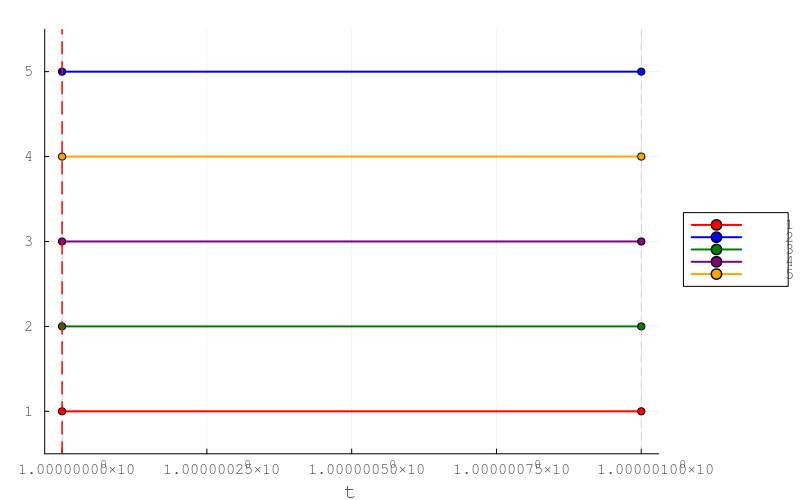

GKS: glyph missing from current font: 38918
GKS: glyph missing from current font: 20301
GKS: invalid bitmap size
GKS: glyph missing from current font: 20195
GKS: glyph missing from current font: 26367
GKS: glyph missing from current font: 26696
GKS: glyph missing from current font: 12398
GKS: glyph missing from current font: 38918
GKS: glyph missing from current font: 20301
GKS: glyph missing from current font: 22793
GKS: glyph missing from current font: 21270
GKS: invalid bitmap size
GKS: glyph missing from current font: 20195
GKS: glyph missing from current font: 26367
GKS: glyph missing from current font: 26696
GKS: glyph missing from current font: 20195
GKS: glyph missing from current font: 26367
GKS: glyph missing from current font: 26696
GKS: glyph missing from current font: 20195
GKS: glyph missing from current font: 26367
GKS: glyph missing from current font: 26696
GKS: glyph missing from current font: 20195
GKS: glyph missing from current font: 26367
GKS: glyph missing from cu

"/workspaces/inulab_julia_devcontainer/src/rank_changes_plot.png"

In [47]:
rank_plot = plot_rank_changes(results)
display(rank_plot)
savefig(rank_plot, "rank_changes_plot.png")

In [48]:
# 新しいCSV保存関数を呼び出す
println(results)
if results !== nothing && hasfield(typeof(results), :rank_change_data)
   output_detailed_df = RankChangeInterval.save_rank_changes_and_rankings_to_csv(results, "rank_change_details.csv")
   display(output_detailed_df)
else
   println("結果に :rank_change_data フィールドが存在しないか、resultsがnothingです。")
end

(all_results_per_alternative = Dict{Int64, Any}(5 => (change_points = Float64[], max_regret_alts = Int64[], max_regret_values = Float64[], intervals = [(1.0, 1.0000010000010002)], interval_data = Any[(change_points = Float64[], max_regret_alts = Int64[], max_regret_values = Float64[], max_alt_at_t_lower = 1, max_alt_at_t_upper = 1, r_min_in_interval = 0.08347389620600001, r_max_in_interval = 0.0834740997670998)], r_M = 0.0834740997670998, r_m = 0.08347389620600001), 4 => (change_points = Float64[], max_regret_alts = Int64[], max_regret_values = Float64[], intervals = [(1.0, 1.0000010000010002)], interval_data = Any[(change_points = Float64[], max_regret_alts = Int64[], max_regret_values = Float64[], max_alt_at_t_lower = 1, max_alt_at_t_upper = 1, r_min_in_interval = 0.063900636564, r_max_in_interval = 0.06390071688371689)], r_M = 0.06390071688371689, r_m = 0.063900636564), 2 => (change_points = Float64[], max_regret_alts = Int64[], max_regret_values = Float64[], intervals = [(1.0, 1.00

Row,t_change_point,alt_1_rank,alt_2_rank,alt_3_rank,alt_4_rank,alt_5_rank
,Float64,Int64,Int64,Int64,Int64,Int64
1,1.0,1,5,2,3,4
